<a href="https://colab.research.google.com/github/xtianu/CV_Tirana/blob/main/M2_Image%20Segmentation/p3_Supervised_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODULE 2: IMAGE SEGMENTATION

Christian Mata, PhD

# PART 3: Supervised vs unsupervised approaches

Let's consider an image segmentation problem in which we should identify a pattern from the background. In this case, we only have two classes of pixels: pixels belonging to the background and pixels belonging to the pattern of interest (vessels in an image of the retina).

In order to understand the different methods covered in this session, we are going to use two different images from a well known dataset on retinal vessel segmentation:

- **Training image** ('vessels_train.jpg'): The one we are using in order to design the sementation method
- **Test image** ('vessels_test.jpg'): The image we are going to use in order to test the previously designed segmentation approach

For each of the images we also have their corresponding ground truth sementation images obtained from an independent expert ('vessels_train_GT.tif' and 'vessels_test_GT.tif'). The ground truth images are going to be used only when constructing a supervised approach. We will also use the GT images as reference in order to quantify the performance of the sementation method.

Make sure you mount your google drive and have the images accessible in a folder:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we take a look to the image dataset:

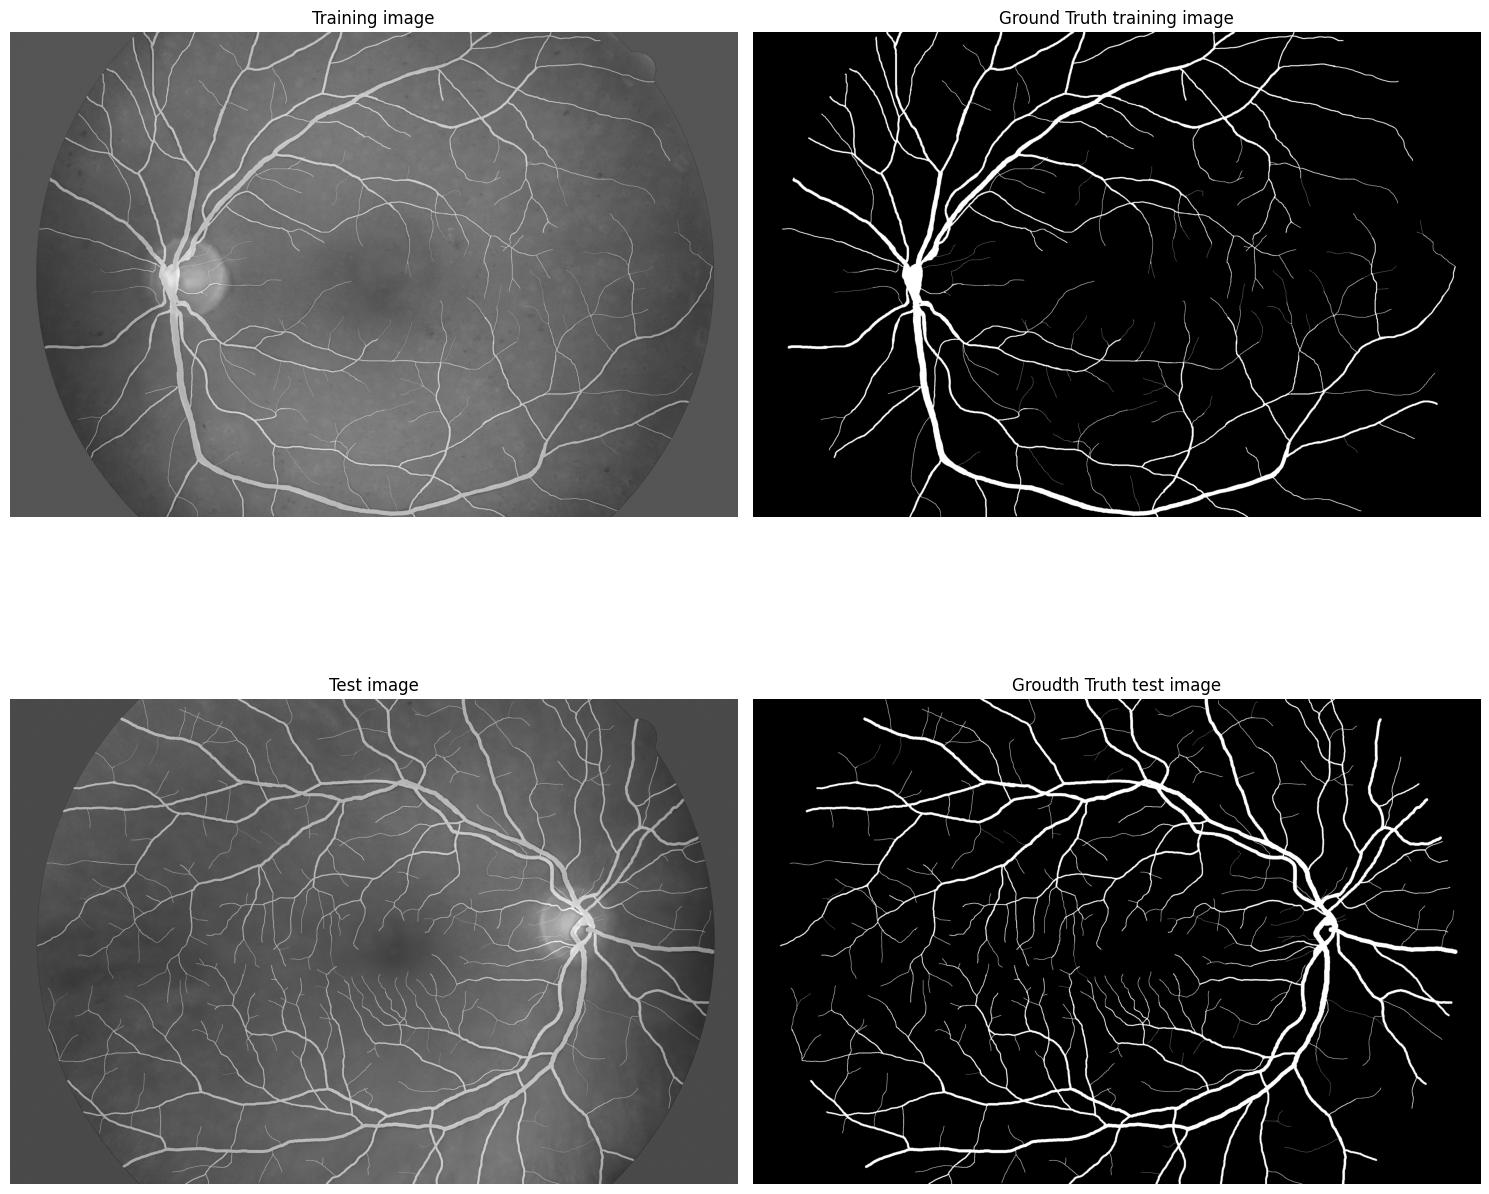

In [3]:
import skimage as sk
import matplotlib.pyplot as plt
from skimage import io
import os
from matplotlib import gridspec

# Path of the folder in your google drive unit where you have the images:

path = '/content/drive/MyDrive/UT/TiranaCV2025/'

I_train = sk.io.imread(os.path.join(path,'vessels_train.jpg'))
I_train_GT = sk.io.imread(os.path.join(path,'vessels_train_GT.tif'))
I_test = sk.io.imread(os.path.join(path,'vessels_test.jpg'))
I_test_GT = sk.io.imread(os.path.join(path,'vessels_test_GT.tif'))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Groudth Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

## Unsupervised approaches:

- Otsu's algorithm


- K-means clustering


- Gaussian Mixture Models + BIC model selection

### Otsu's algorithm:

As a reference, we will first apply well known segmentation approach Otsu's Method. The algorithm finds the threshold that **maximum inter-class variance** $\sigma _{b}^{2}(t)$, defined in terms of the difference between the means of the two clusters in the image histogram (pattern and background, respectively):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$

The algorithm is the following:

1. Compute histogram and probabilities of each intensity level $p(i), i=0,\dots L$ where $L=2^n$ for an n-bit grayscale image.

2. Set up initial $\omega _{i}(0)$ and $\mu _{i}(0)$

3. Step through all possible thresholds $t=1,\ldots L-1$

a) Update $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Compute $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$

4. Desired threshold corresponds to the maximum inter-class variance $\sigma _{b}^{2}(t)$

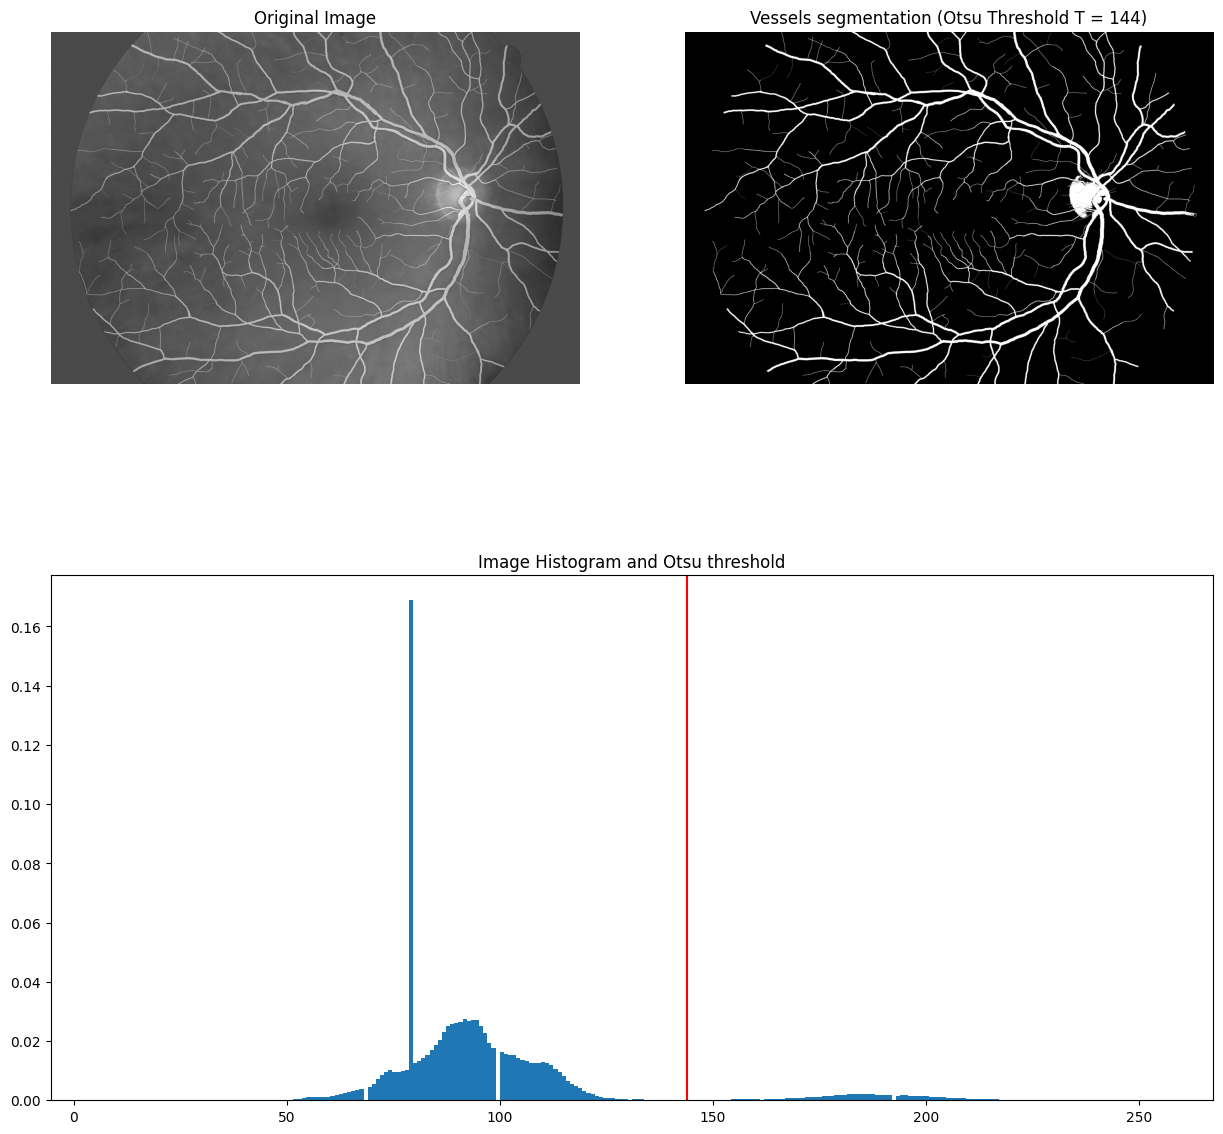

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='r')
ax3.set_title('Image Histogram and Otsu threshold')
plt.show()

The peak in the histogram is due to the fact that the region outside circular lens has been previously replaced by the mean of the image.

### kmeans algorithm:

[1] Specify the number of clusters $k$ to be found in data.

[2] Set initial values for the cluster centroids $\mu^0_1,\dots,\mu^0_k$ (at random or prior knowledge).

[3] Assign each observation to the nearest cluster (euclidean distance).

[4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_k$.

[5] Repeat steps 3-4 until no change in the centroids. Provide final clustering $\mu^n_1,\dots,\mu^n_k$, where $n$ is the number of iterations.

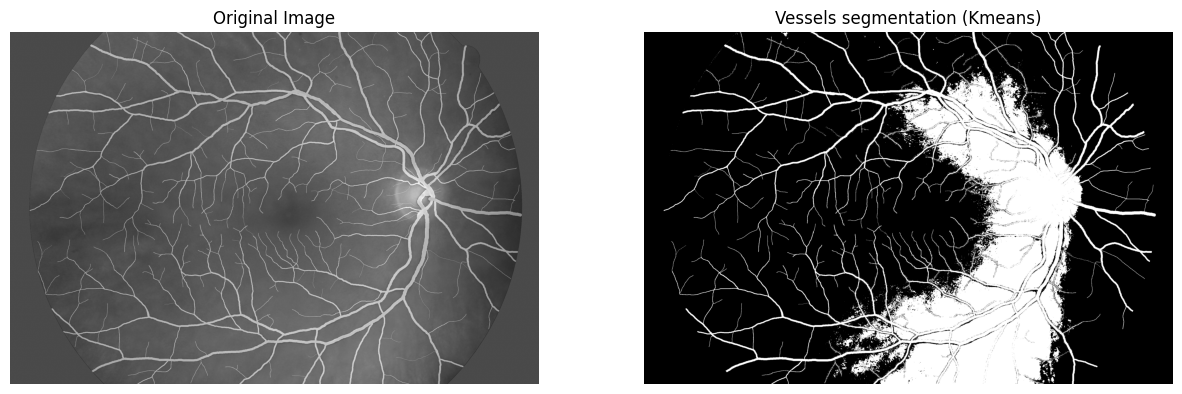

In [5]:
from sklearn.cluster import KMeans
import numpy as np

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8)

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test)
#v_kmeans= np.logical_not(v_kmeans) # use when the pattern is associated to cluster 0 (vessels shoyld be white)
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

### GMM + BIC model selection

In [6]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import mixture

#calcula el BIC per trobar el número de gaussianes òptim
NMAX = 2
bic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(v_I_train)
    bic.append(gmm.bic(v_I_train))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

[np.float64(77185719.14287177)]
[np.float64(77185719.14287177), np.float64(72587343.37342924)]
...and the winner is GMM model G = 2


Then apply the best GMM+BIC model to the test image:

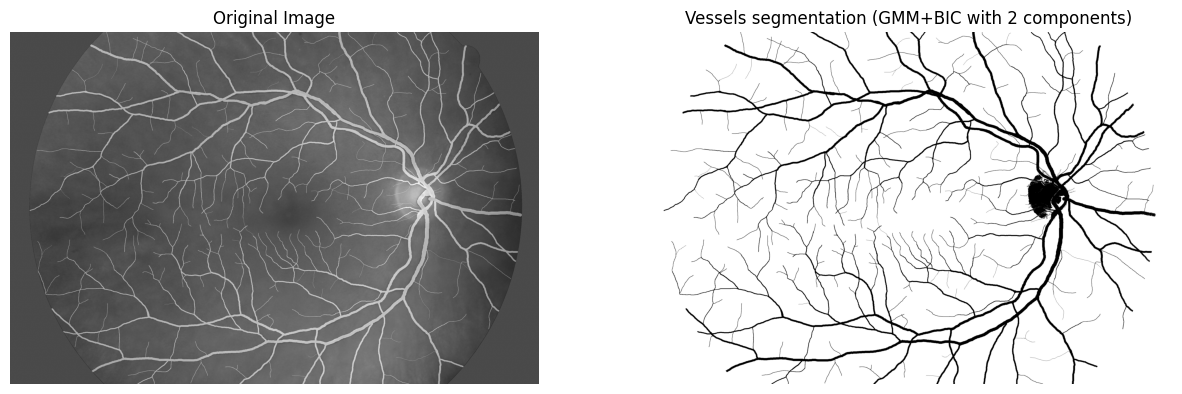

In [7]:
gmmw = mixture.GaussianMixture(n_components=idx_winner+1).fit(v_I_train) # fit again best GMM model
v_agg = gmmw.fit_predict(v_I_test)
I_gmm = np.array(v_agg).reshape(I_test.shape[0],I_test.shape[1])# Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm,cmap='gray')
ax2.set_title('Vessels segmentation (GMM+BIC with {} components)'.format(idx_winner+1))
ax2.set_axis_off()
plt.show()

## Supervised approaches:

- LDA

- QDA

- Bayes Naive Bayes:

### LDA:

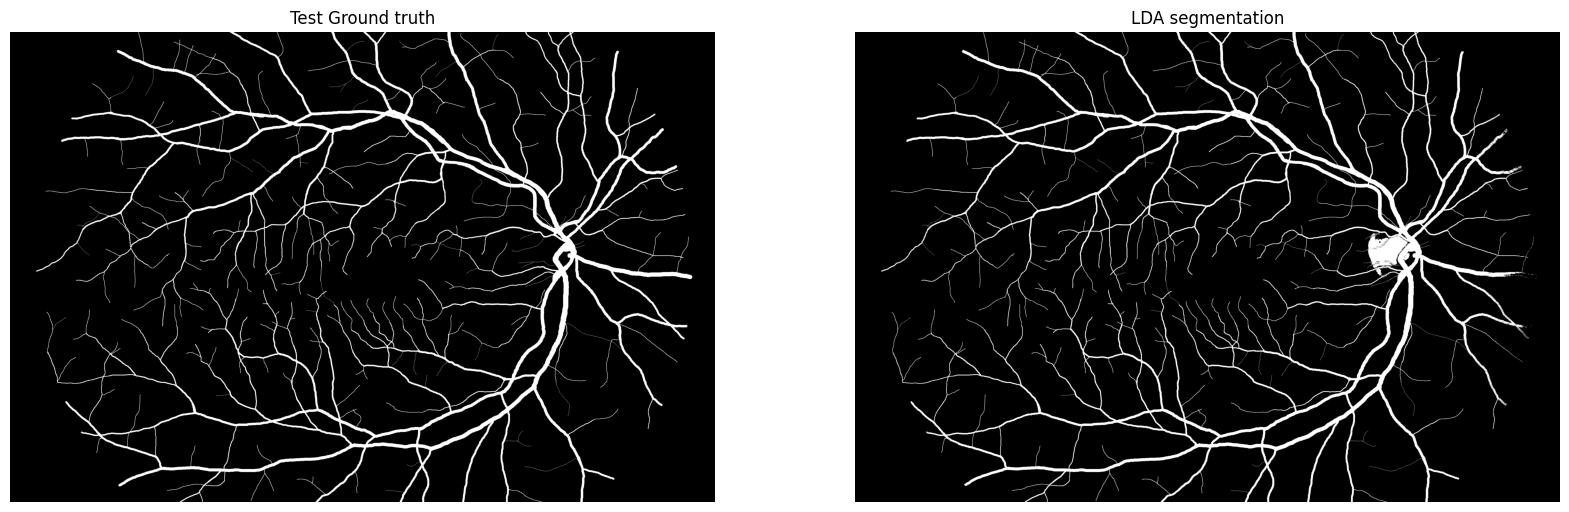

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool)

lda_model = LinearDiscriminantAnalysis(store_covariance=True)
lda_model.fit(v_I_train, v_train_GT.ravel()) # Train with training image and training Ground Truth

# Predict the test image:
v_lda = lda_model.predict(v_I_test)
I_lda = np.array(v_lda).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(I_test_GT, cmap=plt.cm.gray)
ax[0].set_title('Test Ground truth')
ax[0].set_axis_off()

ax[1].imshow(I_lda, cmap=plt.cm.gray)
ax[1].set_title('LDA segmentation')
ax[1].set_axis_off()

plt.show()

### QLA

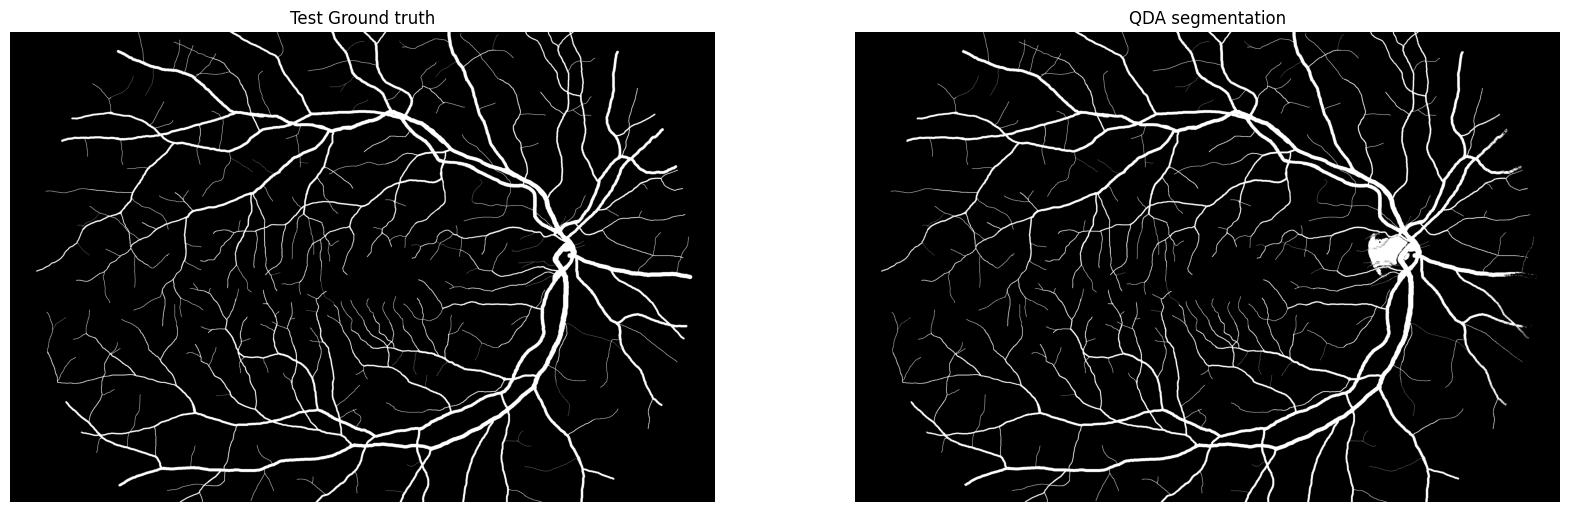

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool)

qda_model = QuadraticDiscriminantAnalysis(store_covariance=True)
qda_model.fit(v_I_train, v_train_GT.ravel()) # Train with training image and training Ground Truth

# Predict the test image:
v_qda = lda_model.predict(v_I_test)
I_qda = np.array(v_qda).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(I_test_GT, cmap=plt.cm.gray)
ax[0].set_title('Test Ground truth')
ax[0].set_axis_off()

ax[1].imshow(I_qda, cmap=plt.cm.gray)
ax[1].set_title('QDA segmentation')
ax[1].set_axis_off()

plt.show()

### Gaussian Naive Bayes

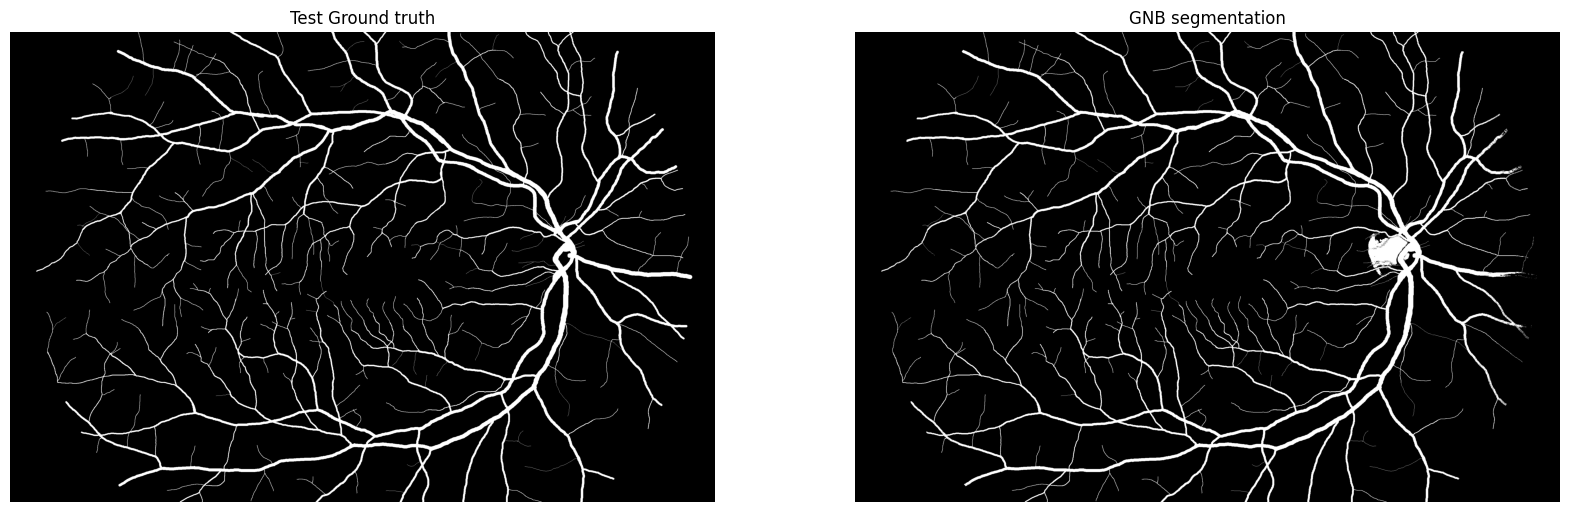

In [10]:
from sklearn.naive_bayes import GaussianNB

v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool)

gnb_model = GaussianNB()
gnb_model.fit(v_I_train, v_train_GT.ravel()) # Train with training image and training Ground Truth

# Predict the test image:
v_gnb = gnb_model.predict(v_I_test)
I_gnb = np.array(v_gnb).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(I_test_GT, cmap=plt.cm.gray)
ax[0].set_title('Test Ground truth')
ax[0].set_axis_off()

ax[1].imshow(I_gnb, cmap=plt.cm.gray)
ax[1].set_title('GNB segmentation')
ax[1].set_axis_off()

plt.show()

## Performance evaluation


In order to evaluate a segmentation algorithm, we should introduce the following quantities:

- True positive (TP): A pattern pixel that has been correctly segmented as pattern
- True negative (TN): A background pixel that has been correctly segmented as background
- False positive (FP): A background pixel that has been mistakenly segmented as pattern (false alarm, Type I error)
- False negative (FN): A pattern pixel that has been mistakenly segmented as bavkground (omission, Type II error)

The confusion matrix is a 2x2 matrix reporting these four values: TP,TNFP,FN.

From them we can define different measures of error:

- Sensitivity, recall, hit rate, or true positive rate (TPR):

$\text{TPR} =\frac{TP}{TP+FN}$

- Specificity, selectivity or true negative rate (TNR):

$\text{TNR} =\frac{TN}{TN+FP}$

- The Sorensen-Dice similarity index:

Measures the similarity between a segmentation mask and the ground truth mask by computing the F1 score
is the harmonic mean of precision and sensitivity:

$\text{DSC}={\frac {2TP}{2TP+FP+FN}}$.

In [11]:
from sklearn.metrics import confusion_matrix

v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool)

CM_lda = confusion_matrix(v_test_GT,np.array(v_lda).astype(np.bool))
tn, fp, fn, tp = CM_lda.ravel()
TPR_lda = tp/(tp+fn)
FPR_lda = fp/(fp+tn)
DSC_lda = 2*tp/(2*tp+fp+fn)

print('LDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_lda,FPR_lda,DSC_lda))

LDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


In [12]:
from sklearn.metrics import confusion_matrix

CM_qda = confusion_matrix(v_test_GT,np.array(v_qda).astype(np.bool))
tn, fp, fn, tp = CM_qda.ravel()
TPR_qda = tp/(tp+fn)
FPR_qda = fp/(fp+tn)
DSC_qda = 2*tp/(2*tp+fp+fn)

print('QDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_qda,FPR_qda,DSC_qda))

QDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


In [13]:
from sklearn.metrics import confusion_matrix

CM_gnb = confusion_matrix(v_test_GT,np.array(v_gnb).astype(np.bool))
tn, fp, fn, tp = CM_gnb.ravel()
TPR_gnb = tp/(tp+fn)
FPR_gnb = fp/(fp+tn)
DSC_gnb = 2*tp/(2*tp+fp+fn)

print('GNB Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_gnb,FPR_gnb,DSC_gnb))

GNB Segmentation: TPR=0.980771759137523, FPR=0.002889739754523344, DSC=0.9705449469418732


In [14]:
CM_qda

array([[7614687,   23025],
       [   9242,  538390]])

In [15]:
CM_gnb

array([[7615641,   22071],
       [  10530,  537102]])